<a href="https://colab.research.google.com/github/RaminTK/TDRP/blob/main/VRP_1T1D-v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 37.1 MB/s eta 0:00:00


# Libraries

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [3]:
# Create an environment with your WLS license
params = {
"WLSACCESSID": 'c5c6ef9a-d24b-4e09-99ba-a30fae3c2de1',
"WLSSECRET": '3809b277-8064-4385-8804-9971d3dc9938',
"LICENSEID": 2536865,
}

# env = gp.Env(params=params)

# # Create the model within the Gurobi environment
# model = gp.Model(env=env)

# Parameters

$d^{t}_{ij}$ Travel time between node $i$ and $j$ by truck, $(i,j) \in A^t$.

$d^{u}_{ij}$ Travel time between node $i$ and $j$ by UAV, $(i,j) \in A^u$.

$M$ A sufficiently large number.

<!-- $L$ & Battery life limit of UAV. -->

$N$ Number of aid recipients.

$L$ Number of aid recipients accessible by truck.

$R$ Number of Trucks.

$V$ Number of UAVs.

<!-- $q$ Relief item capacity limit of UAVs. (unlimited) -->

In [4]:
N = 6
L = 3
R = 1
V = 1
M = 100000  # A large number
a = L + 1
b = N + 1

# Sets


$A^t$  Set of aid recipients served by trucks and depot. $A^t \subset A_U$.

$A^u$  Set of aid recipients served by UAVs and depote (all nodes). $A^u$.

$U$  Set of UAVs. $|U|= V$.

$T$  Set of trucks. $|T| = R$.

In [5]:
A_T = (list(range(L+1)))+[N+1]  # Set of nodes for trucks
A_U = list(range(N+2))# Set of nodes for UAVs

T = list(range(1,R+1))      # Set of trucks

In [6]:
A_T,T,A_U

([0, 1, 2, 3, 7], [1], [0, 1, 2, 3, 4, 5, 6, 7])

## Generate random coordinates for the nodes

In [7]:
# Number of nodes
N += 1

np.random.seed(0)  # For reproducibility
coordinates = np.random.rand(N, 2) * 100  # Generate random coordinates in a 100x100 area

In [8]:
coordinates = np.vstack([coordinates, coordinates[0]])

In [9]:
coordinates

array([[54.88135039, 71.51893664],
       [60.27633761, 54.4883183 ],
       [42.36547993, 64.58941131],
       [43.75872113, 89.17730008],
       [96.36627605, 38.34415188],
       [79.17250381, 52.88949198],
       [56.80445611, 92.55966383],
       [54.88135039, 71.51893664]])

In [10]:
N += 1

## Distance Matrix


In [11]:
euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

In [12]:
euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(N)], index=[f'Node {i}' for i in range(N)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(N)], index=[f'Node {i}' for i in range(N)])

In [13]:
euclidean_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7
Node 0,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,21.128430,0.000000
Node 1,17.864710,0.000000,20.562852,38.420790,39.536284,18.963685,38.229325,17.864710
Node 2,14.306129,20.562852,0.000000,24.627330,60.040816,38.621822,31.477278,14.306129
Node 3,20.869372,38.420790,24.627330,0.000000,73.154383,50.704448,13.477076,20.869372
Node 4,53.118409,39.536284,60.040816,73.154383,0.000000,22.520940,67.115269,53.118409
Node 5,30.612356,18.963685,38.621822,50.704448,22.520940,0.000000,45.541762,30.612356
Node 6,21.128430,38.229325,31.477278,13.477076,67.115269,45.541762,0.000000,21.128430
Node 7,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,21.128430,0.000000


In [14]:
manhattan_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7
Node 0,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,22.963833,0.000000
Node 1,22.425606,0.000000,28.011951,51.206598,52.234105,20.494993,41.543227,22.425606
Node 2,19.445396,28.011951,0.000000,25.981130,80.246056,48.506943,42.409229,19.445396
Node 3,28.780993,51.206598,25.981130,0.000000,103.440703,71.701591,16.428099,28.780993
Node 4,74.659710,52.234105,80.246056,103.440703,0.000000,31.739112,93.777332,74.659710
Node 5,42.920598,20.494993,48.506943,71.701591,31.739112,0.000000,62.038220,42.920598
Node 6,22.963833,41.543227,42.409229,16.428099,93.777332,62.038220,0.000000,22.963833
Node 7,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,22.963833,0.000000


## Plot the nodes

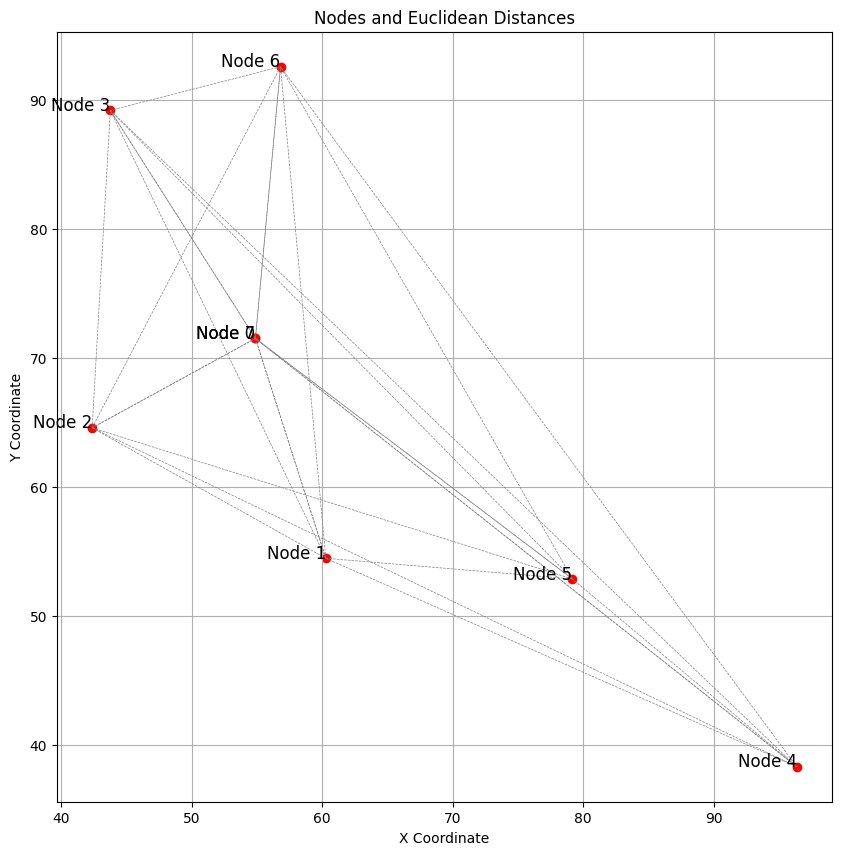

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
for i in range(N):
    for j in range(i + 1, N):
        plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [16]:
euclidean_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7
Node 0,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,21.128430,0.000000
Node 1,17.864710,0.000000,20.562852,38.420790,39.536284,18.963685,38.229325,17.864710
Node 2,14.306129,20.562852,0.000000,24.627330,60.040816,38.621822,31.477278,14.306129
Node 3,20.869372,38.420790,24.627330,0.000000,73.154383,50.704448,13.477076,20.869372
Node 4,53.118409,39.536284,60.040816,73.154383,0.000000,22.520940,67.115269,53.118409
Node 5,30.612356,18.963685,38.621822,50.704448,22.520940,0.000000,45.541762,30.612356
Node 6,21.128430,38.229325,31.477278,13.477076,67.115269,45.541762,0.000000,21.128430
Node 7,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,21.128430,0.000000


In [17]:
manhattan_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6,Node 7
Node 0,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,22.963833,0.000000
Node 1,22.425606,0.000000,28.011951,51.206598,52.234105,20.494993,41.543227,22.425606
Node 2,19.445396,28.011951,0.000000,25.981130,80.246056,48.506943,42.409229,19.445396
Node 3,28.780993,51.206598,25.981130,0.000000,103.440703,71.701591,16.428099,28.780993
Node 4,74.659710,52.234105,80.246056,103.440703,0.000000,31.739112,93.777332,74.659710
Node 5,42.920598,20.494993,48.506943,71.701591,31.739112,0.000000,62.038220,42.920598
Node 6,22.963833,41.543227,42.409229,16.428099,93.777332,62.038220,0.000000,22.963833
Node 7,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,22.963833,0.000000


In [18]:
d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances

# Model

In [19]:
env = gp.Env(params=params)
m = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2536865
Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu


# Indices

$i, j, h, s, g, v$  Equivalently used indices for the nodes of the network (aid recipients and depot).

$t$  Index of trucks.

# Variables

$x^{t}_{ij}$ 1 if truck $t$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in A_t, t \in T$.

$y^{t}_{ijs}$ 1 if UAV $u$ moves from node $i$ to node $j$ and meet it's truck on node $s$; 0 otherwise. $(i,j) \in A_U$ s in for $t \in T$.

$z^{t}_{i}$ Position of node $i$ in the truck $t$ route. $i \in A_E$ for $t \in T$.

$r^{t}_{i}$ Arrival time of truck $t$ at node $i$. $i \in A_E$ for $t \in T$.

$p^{t}_{i}$ Departure time of truck $t$ from node $i$. $i \in A_E$ for $t \in T$.

In [20]:
x = m.addVars(A_T, A_T, T, vtype=GRB.BINARY, name="from i to j truck t travels") #1 if truck $w$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in C_0$ for $w \in W$.
y = m.addVars(A_U, A_U, A_T, T, vtype=GRB.BINARY, name="from i to j uav u travels") #1 if UAV $u$ travels from node $i$ to visit node $j$ and returns to the truck $w$ at node $s$; 0 otherwise. $(i,j,s) \in C_0$ for $w \in W$ and $u \in U$.
z_t = m.addVars(A_T[1:-1],T, vtype=GRB.INTEGER,lb=1.0,ub= a-1, name="truck order") #Position of node $i$ in the truck $w$ route. $i \in C_0$ for $w \in W$.
z_u = m.addVars(A_U[1:-1],T, vtype=GRB.INTEGER,lb=1.0,ub= b-1, name="uav order") #Position of node $i$ in the uav $t$ route. $i \in A_T$ for $t \in T$.
r_t = m.addVars(A_T,T, vtype=GRB.CONTINUOUS, lb=0.0, name="arrival time truck") #Arrival time of truck $w$ at node $i$. $i \in C_0$ for $w \in W$.
p_t = m.addVars(A_T, T, vtype=GRB.CONTINUOUS, lb=0.0, name="departure time truck") #Departure time of truck $w$ from node $i$. $i \in C_0$ for $w \in W$.
r_u = m.addVars(A_U, T, vtype=GRB.CONTINUOUS, lb=0.0, name="arrival time uav")
p_u = m.addVars(A_U, T, vtype=GRB.CONTINUOUS, lb=0.0, name="departure time uav")

# Objective Function

Min $\sum_{i \in A_T} \sum_{t \in T} r^{t}_{i}$ (1)


In [21]:
m.setObjective(gp.quicksum(r_t[i, t] for i in A_T[1:-1] for t in T) + gp.quicksum(r_u[i, u] for i in A_U for u in T), GRB.MINIMIZE)

# Constraints

$\sum_{j \in A_T} x^{t}_{0j} = 1, \forall t \in T$  (2)

In [22]:
m.addConstrs((gp.quicksum(x[0, j, t] for j in A_T[1:-1]) == 1 for t in T), "DepartsFromDepot")

{1: <gurobi.Constr *Awaiting Model Update*>}

$\sum_{i \in C_T} x^{t}_{i,end} = 1, \forall t \in T$ (3)

In [23]:
m.addConstrs((gp.quicksum(x[i, b, t] for i in A_T[1:-1]) == 1 for t in T), "ReturnsToDepot")

{1: <gurobi.Constr *Awaiting Model Update*>}

explain - truck self return ban

In [24]:
m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T for j in A_T if i == j) == 0 for t in T), "explain - self return ban")

m.addConstrs((gp.quicksum(x[i, 0, t] for i in A_T[1:]) == 0 for t in T), "ReturnToStartDepot ban")
m.addConstrs((gp.quicksum(x[b, j, t] for j in A_T[:-1]) == 0 for t in T), "StartFromEndDepot ban")

{1: <gurobi.Constr *Awaiting Model Update*>}

explain - uav self return ban

In [25]:
m.addConstrs((gp.quicksum(y[i, j, s, t] for i in A_U[:-1] for j in A_U[1:] if i == j) == 0 for  s in A_T[1:] for t in T), "explain - self return ban")

m.addConstrs((gp.quicksum(y[i, 0, s, t] for i in A_U[1:] ) == 0 for s in A_T[1:] for t in T), "ReturnToStartDepot ban")
m.addConstrs((gp.quicksum(y[b, j, s, t] for j in A_T[:-1]) == 0 for s in A_T[1:] for t in T), "StartFromEndDepot ban")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (7, 1): <gurobi.Constr *Awaiting Model Update*>}

$\sum_{g \in A_T \atop g \neq i} x^{t}_{gi} = \sum_{j \in A_U \atop j \neq i} x^{t}_{ij}, \forall i \in A_T, \forall t \in T,$ (4)

In [26]:
m.addConstrs((gp.quicksum(x[g, i, t] for g in A_T[:-1] if g != i) == gp.quicksum(x[i, j, t] for j in A_T[1:] if j != i) for i in A_T[1:-1] for t in T), "FlowConservationTruck")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

In [27]:
# m.addConstrs((gp.quicksum(x[g, i, t] for g in A_T[:-1] if g != i) == gp.quicksum(x[i, j, t] for j in A_T[1:] if j != i) for i in A_T for t in T), "FlowConservationTruck")

$\sum_{i \in A_T \atop i \neq j} \sum_{t \in T} x^{t}_{ij} + \sum_{i \in A_U \atop i \neq j} \sum_{s \in A_E} \sum_{u \in U} y^{ut}_{ijs} = 1, \forall j \in A_T,$ (5)


it is only for nodes A_T. we should another one only for nodes unique for A_U (A_U - A_T)

In [28]:
# m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) == 1 for j in A_T[1:]), "VisitExactOnce - Truck")

m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) + gp.quicksum(y[i, j, s, t] for i in A_U[:-1] if i != j for s in A_T for t in T) == 1 for j in A_T[1:]), "VisitOnce - Truck and UAV")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>}

it is only for nodes A_T. we should another one only for nodes unique for A_U (A_U - A_T)

In [29]:
m.addConstrs((gp.quicksum(y[i, j, s, t] for i in A_U[:-1] if i != j for s in A_T for t in T) == 1 for j in A_U[1:]), "VisitOnce - UAV")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>}

$\sum_{h \in A_T \atop h \neq i} x_{hi} + \sum_{g \in A_E \atop g \neq s} x_{gs} \geq 2 \sum_{j \in A_U} y^{ut}_{ijs}, \forall i \in A_T, \forall s \in A_E, \forall u \in U,$ (6)

In [30]:
m.addConstrs((gp.quicksum(x[h, i, t] for h in A_T[:-1] if h != i) + gp.quicksum(x[g, s, t] for g in A_T[:-1] if g != s) >= 2 * gp.quicksum(y[i, j, s, t] for j in A_U) for i in A_T[:-1] for s in A_T[1:] for t in T))

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 7, 1): <gurobi.Constr *Awaiting Model Update*>}

$\sum_{j \in C_D} y^{uw}_{0js} \leq \sum_{g \in C_T \atop g \neq s} x_{gs}, \forall s \in C_E, \forall u \in U,$ (7)

In [31]:
m.addConstrs((gp.quicksum(y[i, j, s, t] for j in A_U) <= gp.quicksum(x[g, s, t] for g in A_T[:-1] if g != s) for s in A_T[1:] for t in T), "UAVRouteConsistency")


{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (7, 1): <gurobi.Constr *Awaiting Model Update*>}

 $r^{t}_{j} + d_{ij} - (1 - x^{t}_{ij}) M \leq p^{t}_{j}, \forall i \in A_T, \forall j \in A_E, i \neq j,$ (8)


In [32]:
m.addConstrs((p_t[i, t] + d_t.iloc[i, j] - (1 - x[i, j, t]) * M <= r_t[j, t] for i in A_T[:-1] for j in A_T[1:] if i != j for t in T), "TruckArrivalTime")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 7, 1): <gurobi.Constr *Awaiting Model Update*>}

$\tilde{t}^{u}_{i} + \bar{d}_{ij} - (1 - \sum_{s \in C_E \atop s \neq j} y^{uw}_{ijs}) M \leq \tilde{l}^{u}_{j}, \forall i \in C_D, \forall j \in C, \forall u \in U,$ (9)

In [33]:
# m.addConstrs((p_u[i, t] + d_u.iloc[i, j] - (1 - gp.quicksum(y[i, j, s, t] for s in A_T if s != j)) * M <= r_u[j, u] for i in A_U for j in A_U if i != j for t in T), "UAVArrivalTime")

In [34]:
m.addConstrs((p_u[i, t] + d_u.iloc[i, j] - (1 - gp.quicksum(y[i, j, s, t] for s in A_T[1:] if s != j)) * M <= r_u[j, t] for i in A_U[:-1] for j in A_U[1:] if i != j for t in T), "UAVArrivalTime")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Upd

${p}^{u}_{i} \leq {r}^{u}_{i}, \forall i \in {A}_{U}, \forall u \in U,$ (10)

In [35]:
m.addConstrs((r_u[i, t] <= p_u[i, t] for i in A_U[1:-1] for t in T), "UAVDepartureTime")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (6, 1): <gurobi.Constr *Awaiting Model Update*>}

$p^{t}_{i} \leq r^{t}_{j}, \forall i \in A_T, \forall t \in W,$ (11)

In [36]:
m.addConstrs((r_t[i, t] <= p_t[i, t] for i in A_T[1:-1] for t in T), "TruckDepartureTime")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

$\tilde{t}^{u}_{i} - (1 - \sum_{j \in C \atop j \neq i} \sum_{s \in C_E} y^{uw}_{ijs}) M \leq l^{w}_{j}, \forall i \in C_D, \forall u \in U, \forall w \in W,$ (12)

UAV must depart from node i after truck arrives there

In [37]:
m.addConstrs((r_t[i, t] - (1 - gp.quicksum(y[i, g, s, t] for g in A_U[1:] if g != i for s in A_T[1:])) * M <= p_u[i, t] for i in A_T[:-1] for t in T), "UAVReturnTime1")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>}

$l^{w}_{s} + \bar{d}_{js} - (1 - \sum_{i \in C_D \atop i \neq j} y^{uw}_{ijs}) M \leq \tilde{t}^{u}_{j}, \forall j \in C, \forall s \in C_E, \forall u \in U, \forall w \in W,$ (13)

UAV must arrive to the intermeeting point s after it's truck

In [38]:
# m.addConstrs((r_t[s, t] + d_u.iloc[j, s] - (1 - gp.quicksum(y[i, j, s, t] for i in A_U if i != j)) * M <= p_u[j, t] for j in A_U for s in A_T for t in T), "UAVReturnTime2")


In [39]:
m.addConstrs((r_t[s, t] - (1 - y[i, s, s, t] ) * M <= p_u[i, t] + d_u.iloc[i, s] for i in A_U[:-1] for s in A_T[1:] for t in T if i != s) , "UAVReturnTime2")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 2, 1): <gurobi.Constr *Awaiting Model Upd

$t^{w}_{i} - (1 - \sum_{j \in C \atop j \neq i} \sum_{s \in C_E} y^{uw}_{ijs}) M \leq \tilde{t}^{u}_{i}, \forall i \in C_D, \forall u \in U,$ (14)

wrong and rep - when truck arives to a node, uav can fly even before truck's departure

(14) say uav must fly after truck's departure

In [40]:
# m.addConstrs((

#     p_t[i, t] - (1 - gp.quicksum(y[i, j, s, t] for j in A_T[1:] if j != i for s in A_T)) * M <= p_u[i, t]

#               for i in A_U for i in A_T for t in T), "UAVReturnTime3")

$\tilde{t}^{u}_{j} + \bar{d}_{js} - \left(2 - \sum_{i \in C_D \atop i \neq j} y^{uw}_{ijs} - \sum_{v \in C \atop v \neq s} \sum_{h \in C_E \atop h \neq j} y^{uw}_{vsh}\right) M \leq \tilde{l}_{su}, \forall s \in C_E, \forall j \in C, \forall u \in U,$ (15)

In [41]:
m.addConstrs((p_u[j, t] + d_u.iloc[j, s] - (2 - gp.quicksum(y[i, j, s, t] for i in A_U[:-1] if i != j) - gp.quicksum(y[v, s, h, t] for v in A_U[:-1] if v != s for h in A_T[1:] if h != j)) * M <= r_u[s, t] for s in A_T[1:] for j in A_U[1:] for t in T), "UAVReturnTime4")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 5, 1): <gurobi.Constr *Awaiting Model Upd

$(c+2) - 1 \leq z_{i} - z_{j} + (c+2) y^{uw}_{ij}, \forall i \in C_{0}, \forall j \in C_E, \forall u \in U, \forall w \in W,$ (16)


MTZ for UAV

In [42]:
m.addConstrs((z_u[i, t] - z_u[j, t] + (b - 1) * y[i, j, s, t] <= b - 2 for i in A_U[1:-1] for j in A_U[1:-1] for s in A_T[1:] for t in T), "MTZ1")

{(1, 1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 7, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 2, 1): <gurobi.Constr *Awaiting Model Up

$1 - (c + 2)(1 - x^{w}_{ij}) \leq z_j - z^{w}_{i}, \forall i \in C_T, \forall j \in C_E, i \neq j, \forall w \in W$ (17)


MTZ for truck

In [43]:
m.addConstrs(z_t[i,t] - z_t[j,t] + (a - 1) * x[i,j,t] <= a - 2 for i in A_T[1:-1] for j in A_T[1:-1] if i != j for t in T)

{(1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>}

$\sum_{j \in A} y^{uw}_{ijs} \leq q, \forall i \in A, \forall s \in A_E,$ (23)

$x^{w}_{ij}, p^{w}_{ij} \in \{0,1\}, \forall i \in V, \forall j \in V,$ (24)

$y^{uw}_{ijs} \in \{0,1\}, \forall i \in V, \forall j \in V, \forall s \in V, \forall u \in U,$ (25)

$1 \leq z^{w}_{i} \leq (a + 2), \forall i \in A_T,$ (26)

$t^{w}_{i}, l^{w}_{j} \geq 0, \forall i \in V$ (27)

$\tilde{t}^{u}_{i}, \tilde{l}^{u}_{i} \geq 0, \forall i \in V, \forall u \in U.$ (28)

# Optimization

In [44]:
m.optimize()

# Display the results
if m.status == GRB.OPTIMAL:
    print("Optimal objective value is :", m.objVal)
    for v in m.getVars():
        if v.x > 0:
            print(v.varName, v.x)
else:
    print("Ther is no optimal solution.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu
Optimize a model with 323 rows, 380 columns and 2425 nonzeros
Model fingerprint: 0xc0442d4c
Variable types: 26 continuous, 354 integer (345 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 107 rows and 336 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Ther is no optimal solution.


House prediction

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the dataset
data = {
    'm2': [50, 65, 38, 57, 58, 58, 45, 50, 58, 52, 55, 50, 55, 55, 57, 55, 45, 45],
    'year': [85, 85, 85, 88, 92, 85, 89, 97, 87, 87, 96, 83, 88, 79, 82, 95, 95, 90],
    'down': [300, 650, 300, 800, 200, 750, 450, 700, 750, 300, 300, 200, 100, 200, 400, 750, 200, 200],
    'rent': [7.5, 6, 6, 0, 17, 0, 6, 0, 0, 9.5, 15.5, 15, 20, 13, 9, 0, 15, 16],
    'parking': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
    'elevator': [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
    'warehouse': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define features and targets for 'down' and 'rent'
features = ['m2', 'year', 'parking', 'elevator', 'warehouse']
X = df[features]
y_down = df['down']
y_rent = df['rent']

# Split the data into training and testing sets for both targets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X, y_down, test_size=0.2, random_state=42)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(X, y_rent, test_size=0.2, random_state=42)

# Initialize and train the models
model_down = LinearRegression()
model_rent = LinearRegression()

model_down.fit(X_train_down, y_train_down)
model_rent.fit(X_train_rent, y_train_rent)

# Function to predict 'down' and 'rent'
def predict_down_rent(details):
    down = model_down.predict([details])
    rent = model_rent.predict([details])
    return down[0], rent[0]

# Example prediction
example_house = [54, 92, 1, 1, 1]
predicted_down, predicted_rent = predict_down_rent(example_house)
print(f"Predicted down payment: {predicted_down}")
print(f"Predicted rent: {predicted_rent}")


Predicted down payment: 324.67676788439763
Predicted rent: 13.301497453712019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the dataset
data = {
    'm2': [50, 65, 38, 57, 58, 58, 45, 50, 58, 52, 55, 50, 55, 55, 57, 55, 45, 45],
    'year': [85, 85, 85, 88, 92, 85, 89, 97, 87, 87, 96, 83, 88, 79, 82, 95, 95, 90],
    'down': [300, 650, 300, 800, 200, 750, 450, 700, 750, 300, 300, 200, 100, 200, 400, 750, 200, 200],
    'rent': [7.5, 6, 6, 0, 17, 0, 6, 0, 0, 9.5, 15.5, 15, 20, 13, 9, 0, 15, 16],
    'parking': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
    'elevator': [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
    'warehouse': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define features and targets for 'down' and 'rent'
features = ['m2', 'year', 'parking', 'elevator', 'warehouse']
X = df[features]
y_down = df['down']
y_rent = df['rent']

# Split the data into training and testing sets for both targets
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X, y_down, test_size=0.2, random_state=42)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(X, y_rent, test_size=0.2, random_state=42)

# Initialize and train the models
model_down = LinearRegression()
model_rent = LinearRegression()

model_down.fit(X_train_down, y_train_down)
model_rent.fit(X_train_rent, y_train_rent)

# Function to predict 'down' and 'rent' with minimum down payment constraint
def predict_down_rent(details, min_down=450):
    down = model_down.predict([details])
    rent = model_rent.predict([details])
    # Ensure down payment is at least the minimum value
    if down[0] < min_down:
        down[0] = min_down
    return down[0], rent[0]

# Example prediction
example_house = [54, 92, 1, 1, 1]
predicted_down, predicted_rent = predict_down_rent(example_house)
print(f"Predicted down payment: {predicted_down}")
print(f"Predicted rent: {predicted_rent}")


Predicted down payment: 450.0
Predicted rent: 13.301497453712019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Create the DataFrame
data = {
    'm2': [50, 65, 38, 57, 58, 58, 45, 50, 58, 52, 55, 50, 55, 55, 57, 55, 45, 45],
    'year': [85, 85, 85, 88, 92, 85, 89, 97, 87, 87, 96, 83, 88, 79, 82, 95, 95, 90],
    'down': [300, 650, 300, 800, 200, 750, 450, 700, 750, 300, 300, 200, 100, 200, 400, 750, 200, 200],
    'rent': [7.5, 6, 6, 0, 17, 0, 6, 0, 0, 9.5, 15.5, 15, 20, 13, 9, 0, 15, 16],
    'parking': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
    'elevator': [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
    'warehouse': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
}

df = pd.DataFrame(data)

# Prepare Features and Target
X = df[['m2', 'year', 'down', 'parking', 'elevator', 'warehouse']]
y = df['rent']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
new_house = np.array([[54, 92, 450, 1, 1, 1]])
predicted_rent = model.predict(new_house)
print(f"Predicted rent for the house: {predicted_rent[0]}")


Predicted rent for the house: 9.49923989984794


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [12]:
5*30

150

In [13]:
600,4.5

(600, 4.5)

In [15]:
450+120,4.5

(570, 4.5)

In [16]:
450,4.5+120/30

(450, 8.5)

In [17]:
500, 4.5+70/30

(500, 6.833333333333334)